In [1]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import torchvision.utils as vutils
import os


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


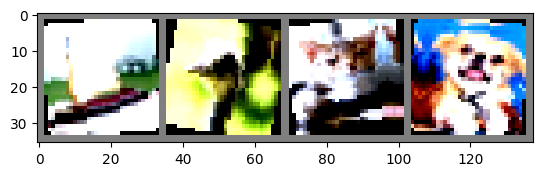

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),  # Using Group Normalization with 8 groups
            nn.Dropout(dropout_value)
        )  # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )  # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    incorrect_examples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Collect incorrect examples
            incorrect_mask = pred.eq(target.view_as(pred)).squeeze() == 0
            incorrect_examples.extend(data[incorrect_mask])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
       
    test_acc.append(100. * correct / len(test_loader.dataset))

    # Plot incorrect examples
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(len(incorrect_examples), 10)):
        plt.subplot(5, 5, i + 1)
        plt.tight_layout()
        # Transpose the image tensor to match the format expected by matplotlib
        img = incorrect_examples[i].cpu().numpy().transpose(1, 2, 0)
        # Normalize the image data to the range [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Predicted: {}, Actual: {}".format(pred[i].cpu().numpy(), target[i].cpu().numpy()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

EPOCH: 0


Loss=1.728602409362793 Batch_id=97 Accuracy=28.10: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s] 



Test set: Average loss: 1.6806, Accuracy: 3962/10000 (39.62%)



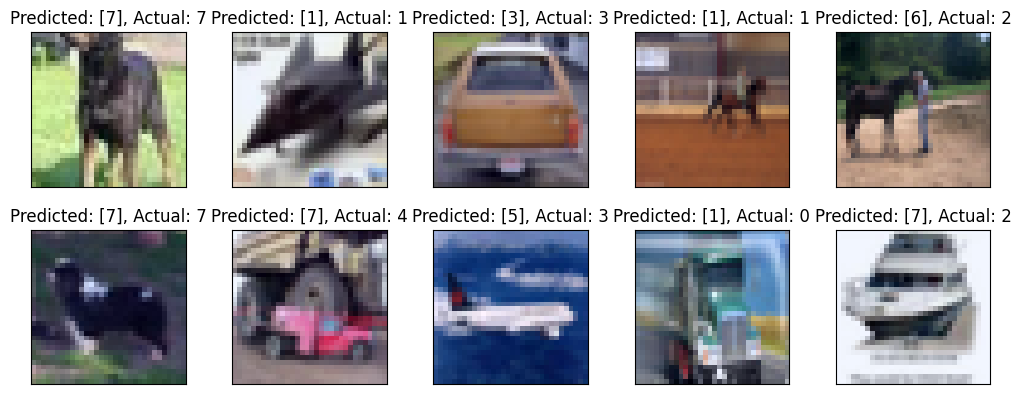

EPOCH: 1


Loss=1.5423827171325684 Batch_id=97 Accuracy=39.76: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 1.4975, Accuracy: 4625/10000 (46.25%)



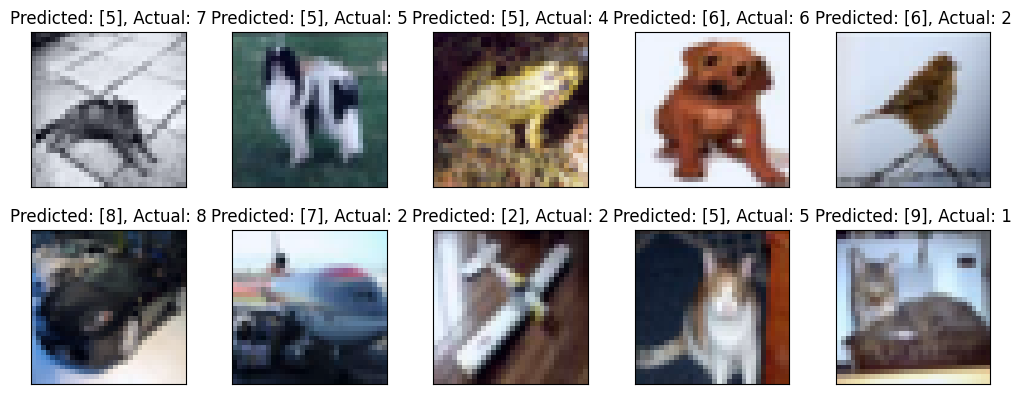

EPOCH: 2


Loss=1.525171160697937 Batch_id=97 Accuracy=45.17: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s] 



Test set: Average loss: 1.4186, Accuracy: 4853/10000 (48.53%)



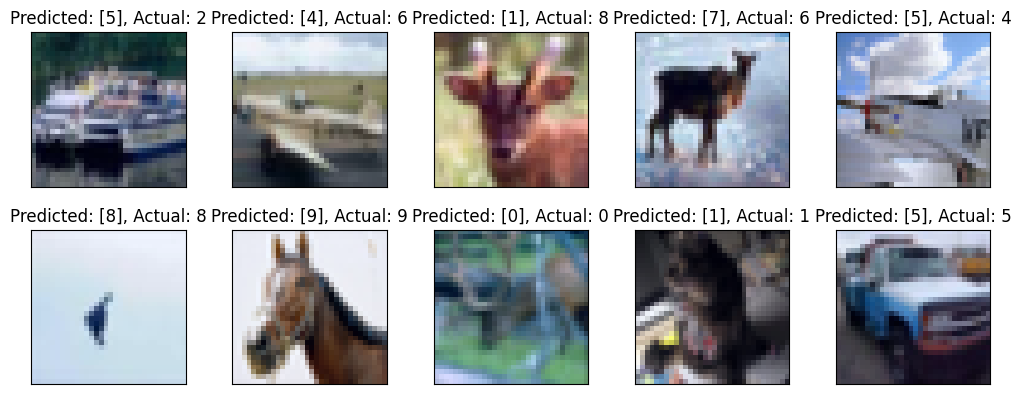

EPOCH: 3


Loss=1.3765203952789307 Batch_id=97 Accuracy=49.52: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]



Test set: Average loss: 1.2741, Accuracy: 5352/10000 (53.52%)



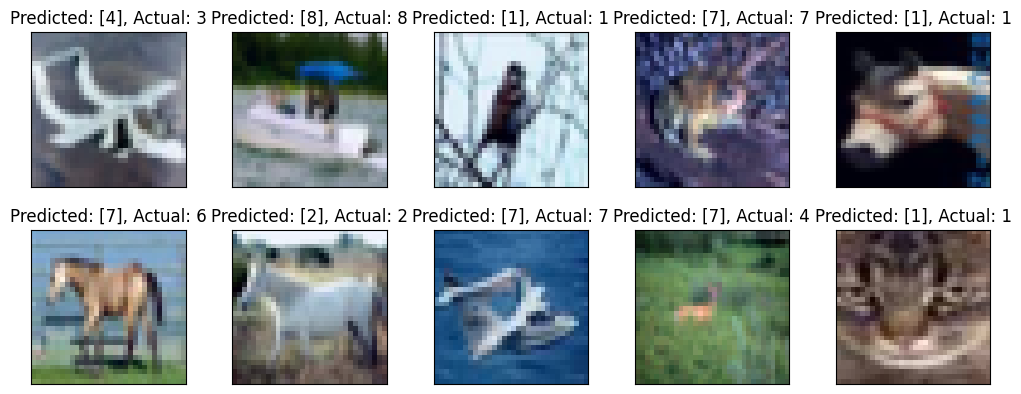

EPOCH: 4


Loss=1.3929609060287476 Batch_id=97 Accuracy=52.62: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]



Test set: Average loss: 1.2353, Accuracy: 5568/10000 (55.68%)



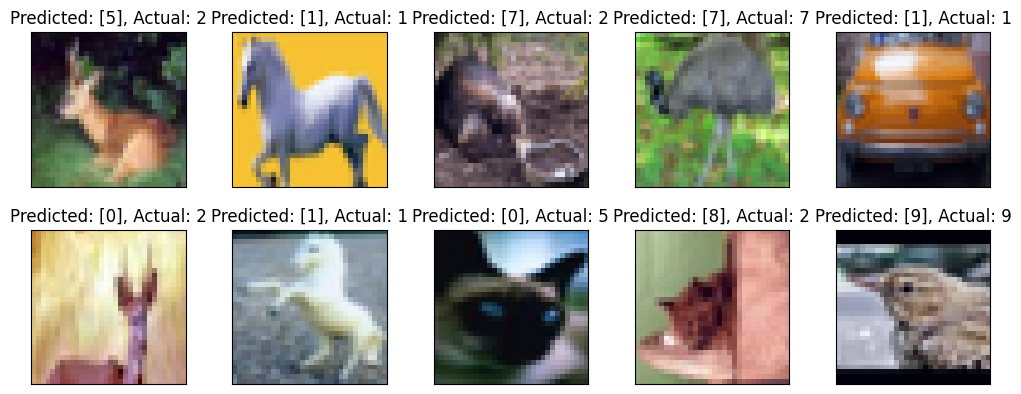

EPOCH: 5


Loss=1.180983543395996 Batch_id=97 Accuracy=54.93: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s] 



Test set: Average loss: 1.1226, Accuracy: 5987/10000 (59.87%)



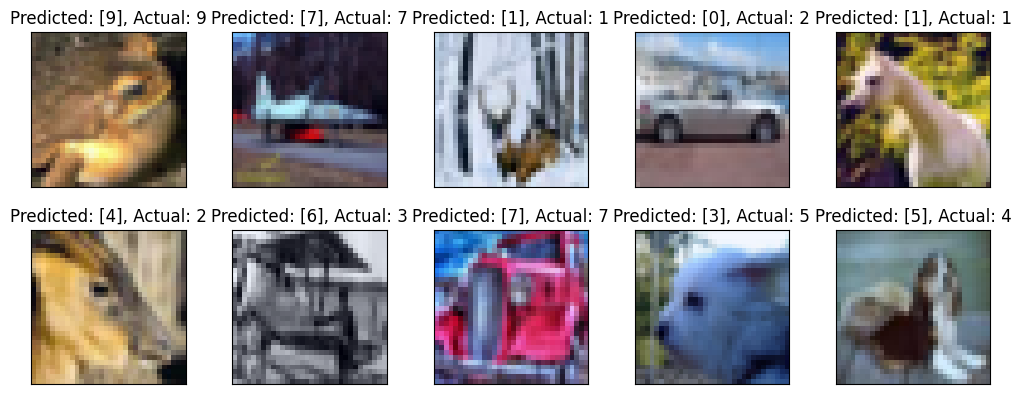

EPOCH: 6


Loss=1.1677583456039429 Batch_id=97 Accuracy=57.16: 100%|██████████| 98/98 [00:16<00:00,  5.79it/s]



Test set: Average loss: 1.1129, Accuracy: 6006/10000 (60.06%)



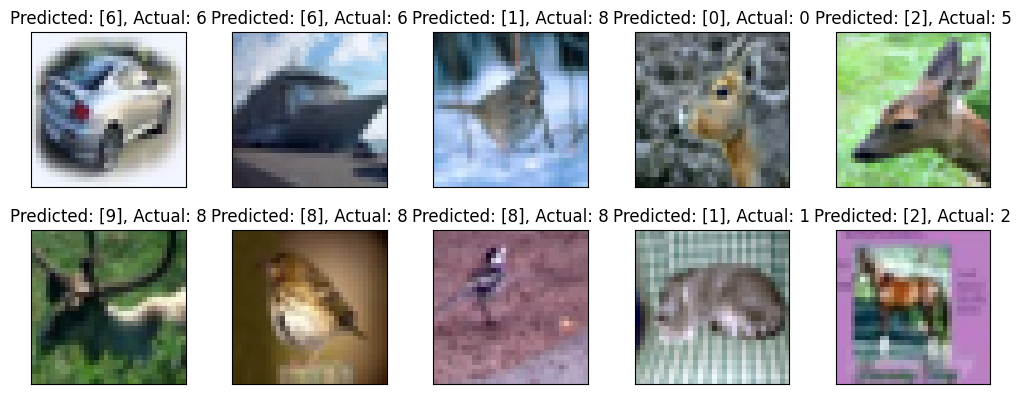

EPOCH: 7


Loss=1.0866405963897705 Batch_id=97 Accuracy=58.54: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]



Test set: Average loss: 1.0331, Accuracy: 6310/10000 (63.10%)



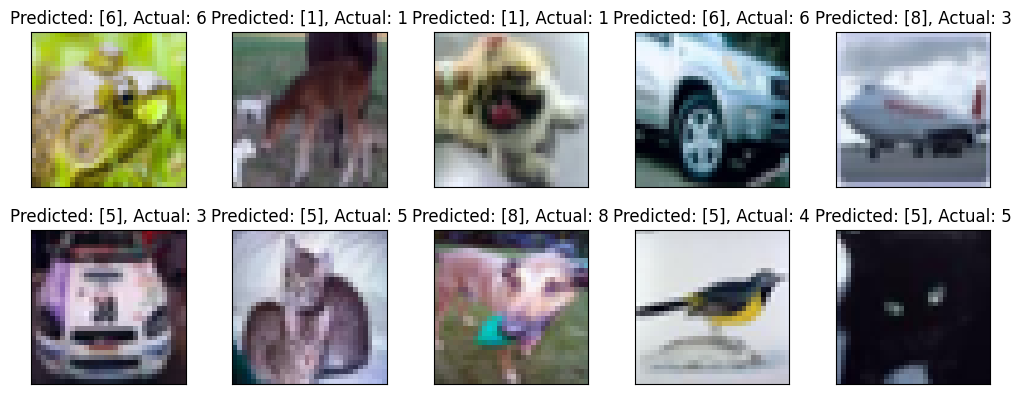

EPOCH: 8


Loss=1.0034376382827759 Batch_id=97 Accuracy=60.15: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.9800, Accuracy: 6468/10000 (64.68%)



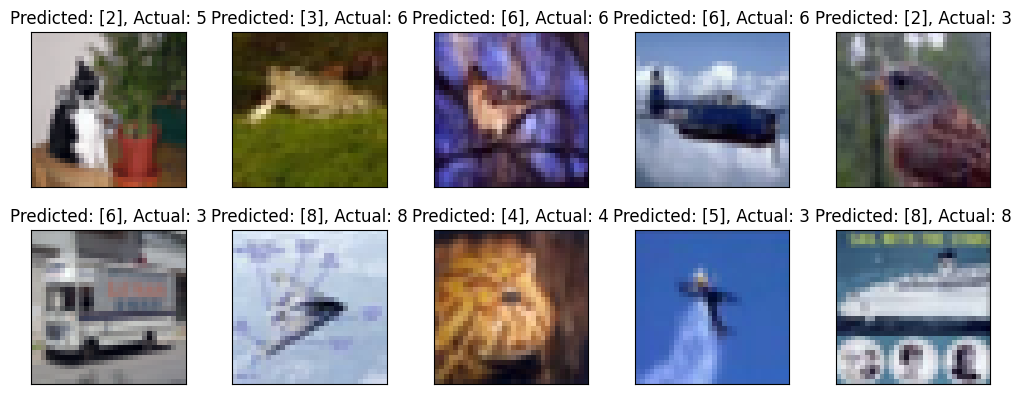

EPOCH: 9


Loss=1.2641671895980835 Batch_id=97 Accuracy=60.65: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.9920, Accuracy: 6443/10000 (64.43%)



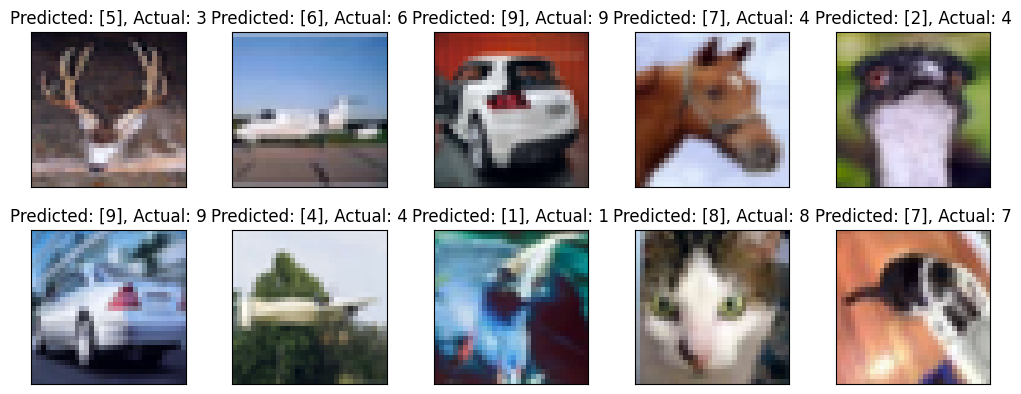

EPOCH: 10


Loss=1.0531306266784668 Batch_id=97 Accuracy=62.22: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.9446, Accuracy: 6652/10000 (66.52%)



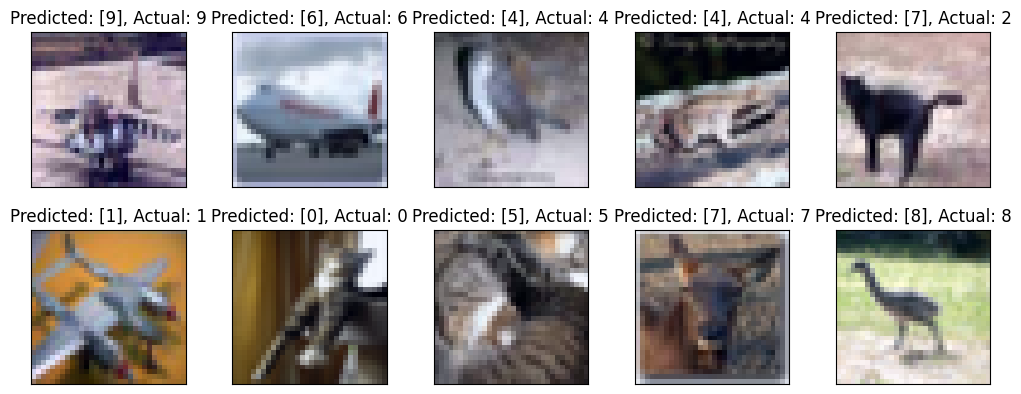

EPOCH: 11


Loss=1.1565485000610352 Batch_id=97 Accuracy=63.53: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]



Test set: Average loss: 0.9289, Accuracy: 6729/10000 (67.29%)



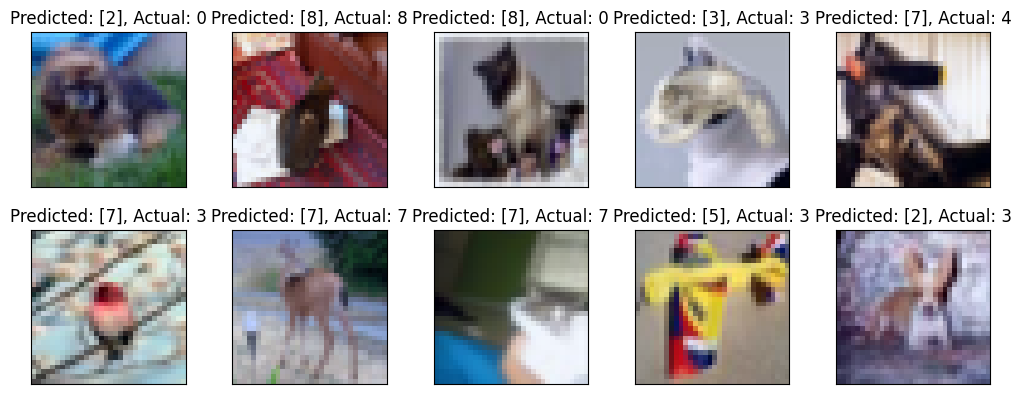

EPOCH: 12


Loss=1.0234287977218628 Batch_id=97 Accuracy=63.89: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]



Test set: Average loss: 0.8904, Accuracy: 6811/10000 (68.11%)



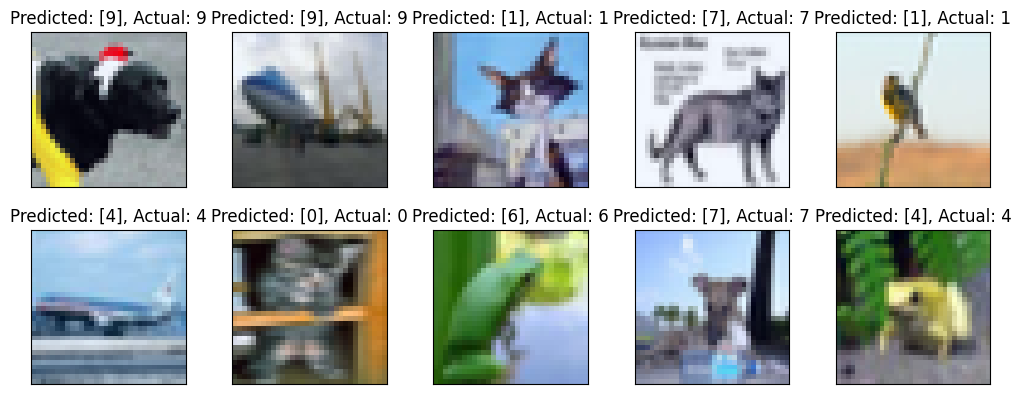

EPOCH: 13


Loss=1.0398451089859009 Batch_id=97 Accuracy=64.86: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]



Test set: Average loss: 0.8802, Accuracy: 6864/10000 (68.64%)



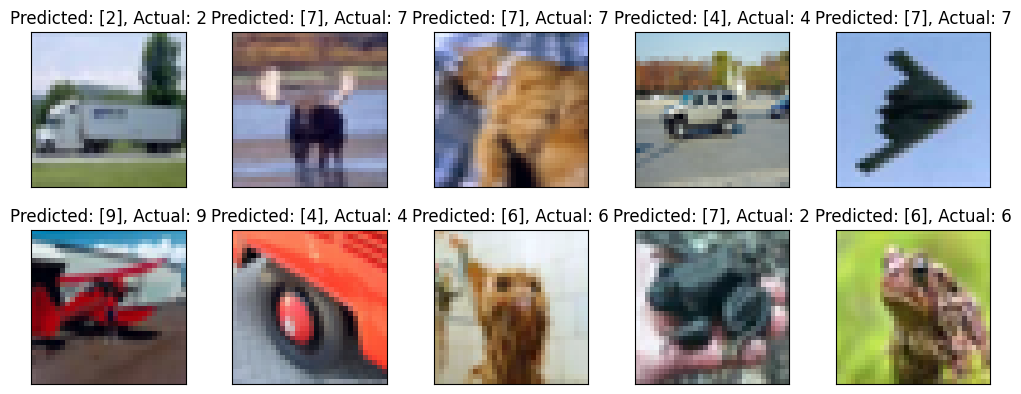

EPOCH: 14


Loss=0.9174363017082214 Batch_id=97 Accuracy=65.70: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]



Test set: Average loss: 0.9031, Accuracy: 6830/10000 (68.30%)



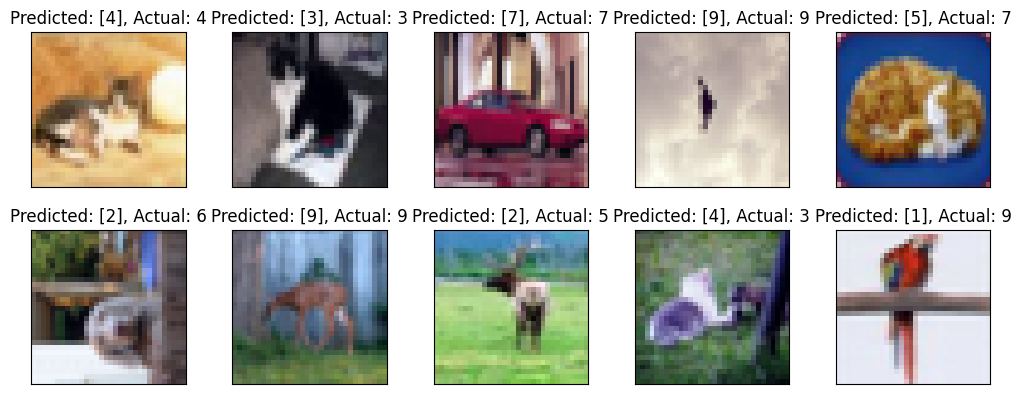

EPOCH: 15


Loss=0.8704221844673157 Batch_id=97 Accuracy=66.03: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.8363, Accuracy: 7028/10000 (70.28%)



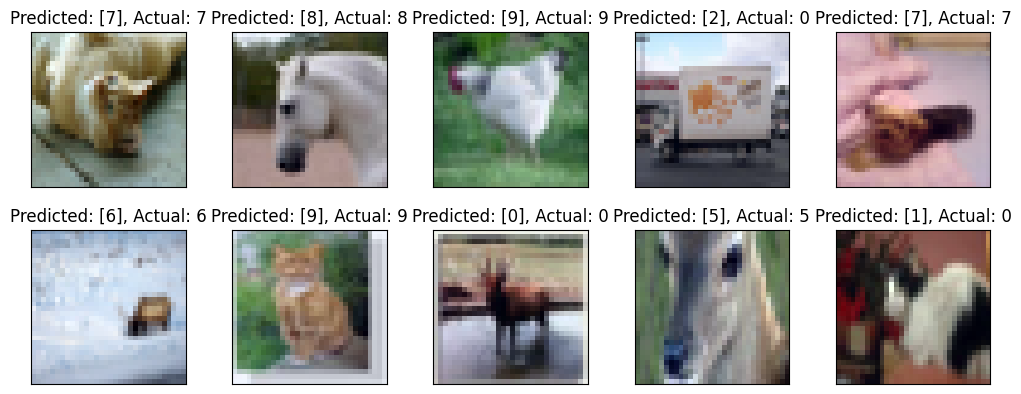

EPOCH: 16


Loss=0.9633995890617371 Batch_id=97 Accuracy=66.48: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]



Test set: Average loss: 0.8246, Accuracy: 7083/10000 (70.83%)



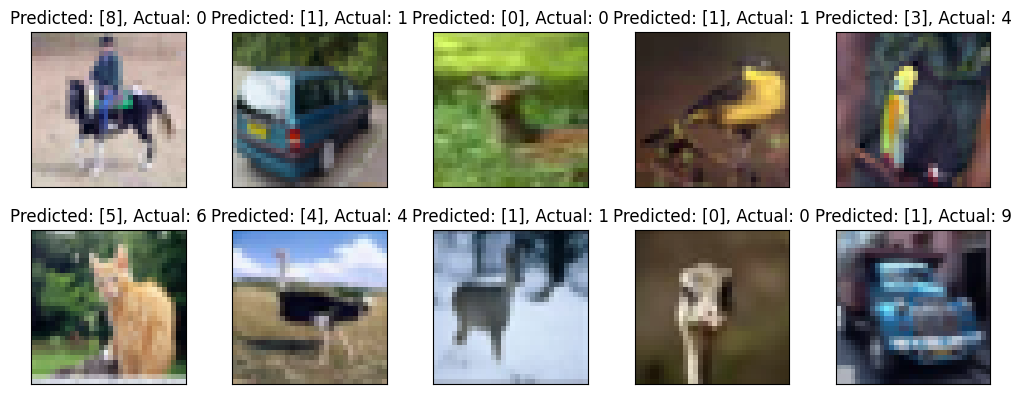

EPOCH: 17


Loss=0.9412590861320496 Batch_id=97 Accuracy=67.37: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 0.7908, Accuracy: 7205/10000 (72.05%)



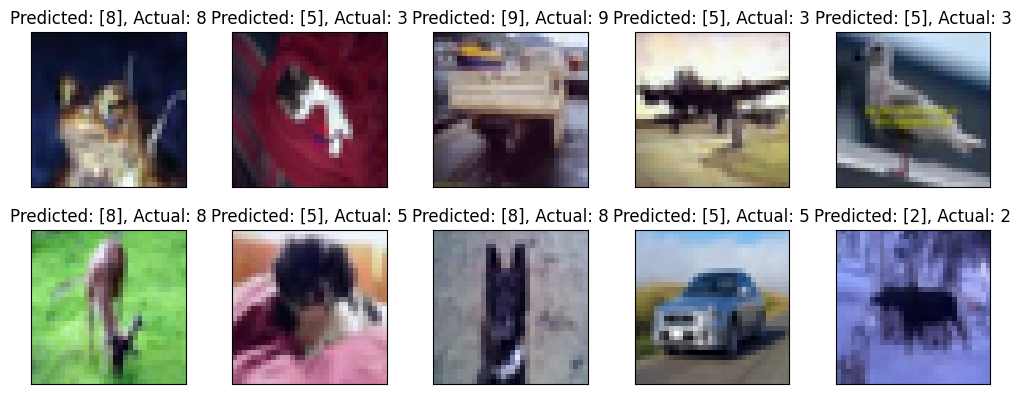

EPOCH: 18


Loss=0.9569554924964905 Batch_id=97 Accuracy=67.65: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.8220, Accuracy: 7113/10000 (71.13%)



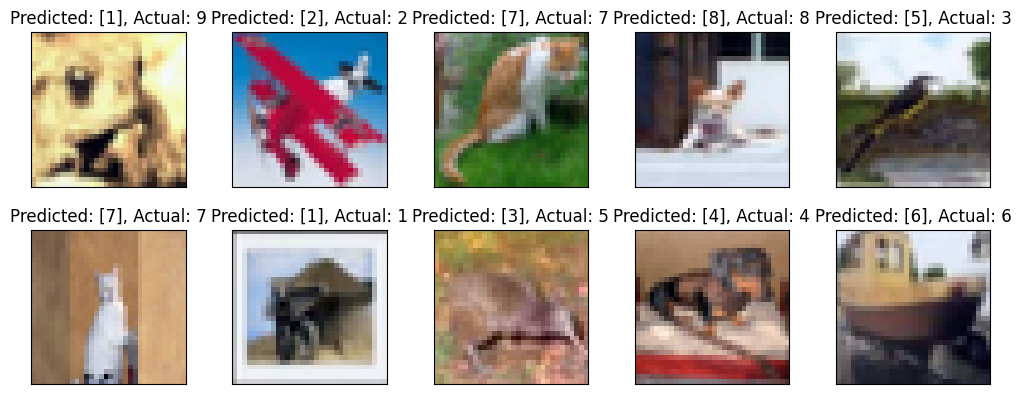

EPOCH: 19


Loss=0.8658055067062378 Batch_id=97 Accuracy=68.18: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]



Test set: Average loss: 0.7793, Accuracy: 7278/10000 (72.78%)



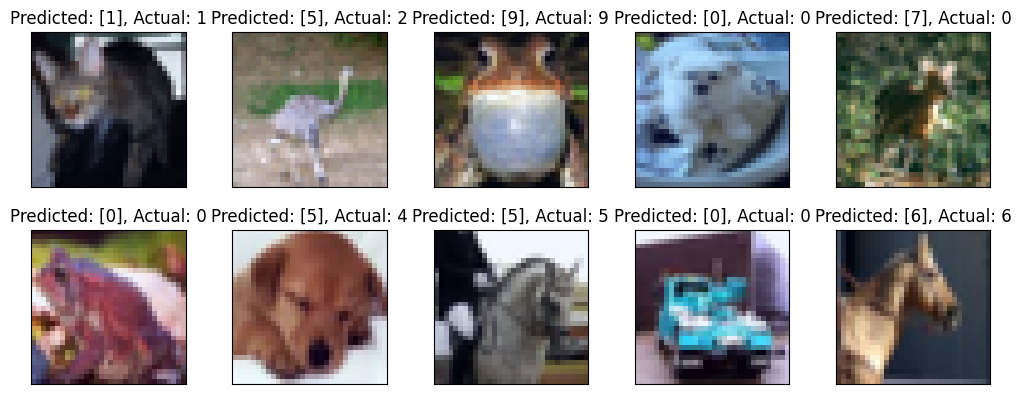

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)